In [1]:
import os
import matplotlib.pyplot as plt
import SimpleITK as sitk
import numpy as np

from MRLCinema.readcine.readcines import readcines, SliceDirection
from MRLCinema.extract_motion import prepare_motion_analysis, perform_motion_analysis
from MRLCinema.report import create_report
from MRLCinema.patient_data import read_cine_patient_ID, find_cine_frame_of_reference
from MRLCinema.patient_data import find_structure_set, find_plan, prescription
from U2Dose.dicomio.rtstruct import RtStruct
from U2Dose.dicomio.rtplan import RtPlan


In [2]:
path = '/mnt/P/TERAPI/FYSIKER/David_Tilly/cine_conversion/1.3.46.670589.11.79101.5.0.17796.2024112808532524002'
path = '/mnt/P/TERAPI/FYSIKER/David_Tilly/cine_conversion/1.3.46.670589.11.79101.5.0.16236.2024102909043045002'
path = '/mnt/P/TERAPI/FYSIKER/David_Tilly/cine_conversion/1.3.46.670589.11.79101.5.0.17796.2024112811114308006'

patient_data_root= f'/mnt/P/TERAPI/MRLINAC/QA/RTQADATA/PATIENT_DATA'
patient_ID = read_cine_patient_ID(path)
frame_of_ref = find_cine_frame_of_reference(path)
rtss = find_structure_set(patient_data_root, patient_ID, frame_of_ref)
rtplan = find_plan(patient_data_root, patient_ID, frame_of_ref)
prescribed_dose, number_of_fractions = prescription(rtplan)


rtss.all_roi_names()

['PTV_42.7',
 'Z_MM',
 'Bladder',
 'External',
 'Z_Bone',
 'Rectum',
 'PenileBulb',
 'Femur_R(Upper)',
 'Femur_L(Upper)',
 'Z_External',
 'CTVT_42.7',
 'Z1-Bridge',
 'Z10-Couch Support',
 'Z2a-Bridge',
 'Z2b-Bridge',
 'Z3-Bridge',
 'Z4-Couch Support',
 'Z5-Hard-plate',
 'Z6-Couch Support',
 'Z7-Couch Support',
 'Z8-Mattress']

 ## Read all cines

In [3]:
cine_directory = os.path.join(path, 'TwoDImages')

import time
start = time.time()
cines = readcines(cine_directory, max_n=1500)

## Perform motion analysis

In [4]:
prepared_cines, times, masks = prepare_motion_analysis(cines, rtss)
transversals, sagittals, coronals = prepared_cines
[times_transversal, times_sagittal, times_coronal] = times
mask_transversal, mask_sagittal, mask_coronal = masks

displacements_transversal = perform_motion_analysis(transversals, mask_transversal) 
displacements_sagittal = perform_motion_analysis(sagittals, mask_sagittal)
displacements_coronal = perform_motion_analysis(coronals, mask_coronal) 
displacements = [displacements_transversal, displacements_sagittal, displacements_coronal] 



start parameter map
None
end parameter map

ParameterObject (0x2bbe7820)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 419114
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (AutomaticParameterEstimation "true")
  (CheckNumberOfSamples "true")
  (DefaultPixelValue 0)
  (FinalBSplineInterpolationOrder 3)
  (FinalGridSpacingInPhysicalUnits 8)
  (FixedImagePyramid "FixedSmoothingImagePyramid")
  (GridSpacingSchedule 2.80322 1.9881 1.41 1)
  (ImageSampler "RandomCoordinate")
  (Interpolator "ReducedDimensionBSplineInterpolator")
  (MaximumNumberOfIterations 256)
  (MaximumNumberOfSamplingAttempts 8)
  (Metric "VarianceOverLastDimensionMetric")
  (MovingImagePyramid "MovingSmoothingImagePyramid")
  (NewSamplesEveryIteration "true")
  (NumberOfResolutions 1)
  (NumberOfSamplesForExactGradient 4096)
  (NumberOfSpatialSamples 2048)
  (Optimizer "AdaptiveStochasticGradientDescent")
  (Registration "MultiResolutionRegistration")
  (Resa

In [5]:


displacements = [displacements_transversal, displacements_sagittal, displacements_coronal] 
times = [times_transversal, times_sagittal, times_coronal]
report = create_report(patient_ID, cine_directory, rtplan.plan_name, times, displacements)
report.keys()


dict_keys(['PatientID', 'CinePath', 'PlanLabel', 'Times Transversal', 'Displacement Transversal X', 'Displacement Transversal Y', 'Times Sagittal', 'Displacement Sagittal Y', 'Displacement Sagittal Z', 'Times Coronal', 'Displacement Coronal X', 'Displacement Coronal Z', 'version'])

In [6]:
#displacements, times = extract_motion(cines, rtss=rtss) 
#[displacements_transversal, displacements_sagittal, displacements_coronal] = displacements
#[times_transversal, times_sagittal, times_coronal] = times

#motion_statistics(displacements_transversal, displacements_sagittal, displacements_coronal, percentile=0.98)

## Visualise motion

interactive(children=(IntSlider(value=0, description='w', max=6730), Output()), _dom_classes=('widget-interact…

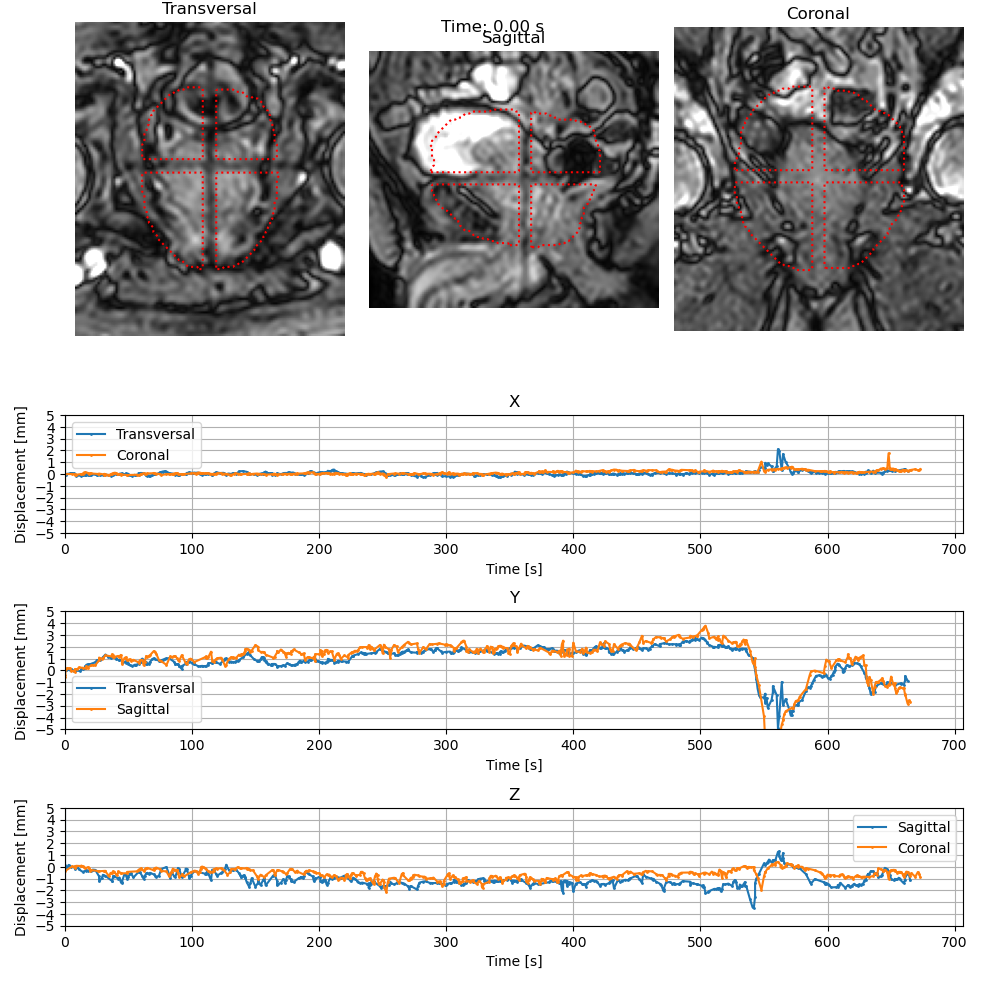

In [8]:

%matplotlib ipympl
from ipywidgets import *


x = times_sagittal
y = displacements_sagittal[:,1]
fig = plt.figure(figsize=(25/2.54, 25/2.54))
gs = fig.add_gridspec(5, 3)

ax_trans = fig.add_subplot(gs[0:2, 0])
ax_sagittal = fig.add_subplot(gs[0:2, 1])
ax_coronal = fig.add_subplot(gs[0:2, 2])
ax_trans.set_axis_off()
ax_sagittal.set_axis_off()
ax_coronal.set_axis_off()
ax_trans.set_title('Transversal')
ax_sagittal.set_title('Sagittal')
ax_coronal.set_title('Coronal')

ax_x = fig.add_subplot(gs[2, 0:4])
ax_y = fig.add_subplot(gs[3, 0:3])
ax_z = fig.add_subplot(gs[4, 0:3])
ax_x.set_title('X')
ax_y.set_title('Y')
ax_z.set_title('Z')

np_transversal = sitk.GetArrayFromImage(transversals[10])
im_transversal = ax_trans.imshow(np_transversal, cmap='gray', origin='lower', vmin=0, vmax=2048)
ax_trans.contour(sitk.GetArrayFromImage(mask_transversal), [0.5], colors='red', linestyles='dotted')

np_sagittal = sitk.GetArrayFromImage(sagittals[10])
im_sagittal = ax_sagittal.imshow(np_sagittal, cmap='gray', origin='lower', vmin=0, vmax=2048)
ax_sagittal.contour(sitk.GetArrayFromImage(mask_sagittal), [0.5], colors='red', linestyles='dotted')

np_coronal = sitk.GetArrayFromImage(coronals[10])
im_coronal = ax_coronal.imshow(np_coronal, cmap='gray', origin='lower', vmin=0, vmax=2048)
ax_coronal.contour(sitk.GetArrayFromImage(mask_coronal), [0.5], colors='red', linestyles='dotted')

max_recorded_time = max(max(max(times_transversal), max(times_sagittal)), max(times_coronal))

for ax in [ax_x, ax_y, ax_z]: 
    ax.set_xlim([0, 1.05 * max_recorded_time])
    ax.set_ylim([-5, 5])
    ax.grid()
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Displacement [mm]')
    ax.set_yticks([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])

#
# X-direction
#
t = times_transversal
x = displacements_transversal[:,0]
ax_x.plot(t, x, label='Transversal', color='C0', marker='o', markersize=1)

t = times_coronal
x = displacements_coronal[:,0]
ax_x.plot(t, x, label='Coronal', color='C1', marker='o', markersize=1)
ax_x.legend()

time_marker_x, = ax_x.plot([0,0],[-5, 5])

#
# Y-direction
#
t = times_transversal
y = displacements_transversal[:,1]
ax_y.plot(t, y, label='Transversal', color='C0', marker='o', markersize=1)

t = times_sagittal
y = displacements_sagittal[:,0]
ax_y.plot(t, y, label='Sagittal', color='C1', marker='o', markersize=1)
ax_y.legend()

time_marker_y, = ax_y.plot([0,0],[-5, 5])


#
# Z-direction
#
t = times_sagittal
z = displacements_sagittal[:,1]
ax_z.plot(t, z, label='Sagittal', color='C0', marker='o', markersize=1)

t = times_coronal
z = displacements_coronal[:,1]
ax_z.plot(t, z, label='Coronal', color='C1', marker='o', markersize=1)
ax_z.legend()

time_marker_z, = ax_z.plot([0,0],[-5, 5])


times_plot = np.arange(0, max_recorded_time + 0.01, 0.1)

def time_to_index(times, t):
    return np.argmin(np.abs(times - t))

fig.tight_layout()

def update(w=1):

    fig.suptitle(f"Time: {times_plot[w]:.2f} s")
    time_marker_x.set_xdata([times_plot[w],times_plot[w]])
    time_marker_y.set_xdata([times_plot[w],times_plot[w]])
    time_marker_z.set_xdata([times_plot[w],times_plot[w]])

    t_i = time_to_index(times_transversal, times_plot[w])
    np_transversal = sitk.GetArrayFromImage(transversals[t_i])
    im_transversal.set_array(np_transversal)

    t_i = time_to_index(times_sagittal, times_plot[w])
    np_sagittal = sitk.GetArrayFromImage(sagittals[t_i])
    im_sagittal.set_array(np_sagittal)

    t_i = time_to_index(times_coronal, times_plot[w])
    np_coronal = sitk.GetArrayFromImage(coronals[t_i])
    im_coronal.set_array(np_coronal)

    fig.canvas.draw_idle()

interact(update, w=widgets.IntSlider(value=0, min=0, max=len(times_plot)-1,step=1));